# Variational Auto-Encoder

Auto-encoder is a type of neural network that can learn a compact representation (encoding) of a dataset. 

Auto-encoders can be used for several purpose, including:
- Dimensionality reduction, for the purpose of plotting, or to make further computations easier.
- Data generation: create new data points resembling instances of the training set

VAE uses a variational bayesian approach, i.e. it makes assumption about the distribution of the encoding and uses probability theory and statistical tools to train the encoder and decoders.

We'll use VAE to cluster and classify instances of the [Epileptic Seizure Recognition Data Set](https://archive.ics.uci.edu/ml/datasets/Epileptic+Seizure+Recognition).

Data points have 178 dimensions, so we'll use VAE to come up with a more compact representation, perhaps in as few as 2 or 3 dimensions. We will then apply clustering and classification (seizure vs no seizure) techniques before and after the dimensionality reduction, and see what works best.

Resources:
- [VAE original paper](https://arxiv.org/pdf/1312.6114.pdf)
- [Good explanations of some of the maths in the paper](https://blog.evjang.com/2016/08/variational-bayes.html)
- [Implementing VAE with Tensorflow](https://danijar.com/building-variational-auto-encoders-in-tensorflow/)

In [1]:
import collections

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.cluster
import sklearn.manifold
import sklearn.model_selection
import sklearn.preprocessing
import tensorflow as tf

from classifier import BinaryClassifier
from vae_model import VariationalAutoEncoder

sns.set(font_scale=1.5, palette='colorblind')

/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Data

In [2]:
dataset = pd.read_csv("data/epileptic_seizure_dataset.csv")

In [3]:
for i in range(0, 178):
    dataset[f'X{i+1}'] = dataset[f'X{i+1}'].astype(np.float32)

dataset.head()

,id,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135.0,190.0,229.0,223.0,192.0,125.0,55.0,-9.0,-33.0,...,-17.0,-15.0,-31.0,-77.0,-103.0,-127.0,-116.0,-83.0,-51.0,4
1,X15.V1.924,386.0,382.0,356.0,331.0,320.0,315.0,307.0,272.0,244.0,...,164.0,150.0,146.0,152.0,157.0,156.0,154.0,143.0,129.0,1
2,X8.V1.1,-32.0,-39.0,-47.0,-37.0,-32.0,-36.0,-57.0,-73.0,-85.0,...,57.0,64.0,48.0,19.0,-12.0,-30.0,-35.0,-35.0,-36.0,5
3,X16.V1.60,-105.0,-101.0,-96.0,-92.0,-89.0,-95.0,-102.0,-100.0,-87.0,...,-82.0,-81.0,-80.0,-77.0,-85.0,-77.0,-72.0,-69.0,-65.0,5
4,X20.V1.54,-9.0,-65.0,-98.0,-102.0,-78.0,-48.0,-16.0,0.0,-21.0,...,4.0,2.0,-12.0,-32.0,-41.0,-65.0,-83.0,-89.0,-73.0,5


In [4]:
X = dataset[dataset.columns[1:-1]].values
y = dataset['y']

scaler = sklearn.preprocessing.StandardScaler()
X_norm = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X_norm, y, test_size=0.2, random_state=444)

# Dimensionality reduction (from 178 to 3)

In [5]:
vae_cls = VariationalAutoEncoder(178, 3)

In [6]:
def random_draw(x, y=None, batch_size=100):
    indices = np.random.randint(0, len(x), batch_size)
    if y is not None:
        return x[indices], y[indices]
    else:
        return x[indices]

def train_vae(vae_cls, x, x_test, learning_rate, n_epochs, batch_size, name='vae'):
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        tf.local_variables_initializer().run()
        
        for i, epoch in enumerate(range(n_epochs)):            
            x_batch = random_draw(x, batch_size=batch_size)

            sess.run(
                vae_cls.train_op, 
                feed_dict={
                    vae_cls.x: x_batch, 
                    vae_cls.learning_rate: learning_rate,
                },
            )
            
            if i % 1000 == 0:
                elbo_test = sess.run(vae_cls.elbo_loss, feed_dict={vae_cls.x: x_test})
                print(f'Iteration {i} / {n_epochs}: elbo test set = {elbo_test}')
        
        return saver.save(sess, f'./{name}.ckpt')

In [7]:
save_path = train_vae(vae_cls, X_train, X_test, 0.001, 5000, 100)

Iteration 0 / 5000: elbo test set = -540.11083984375
Iteration 1000 / 5000: elbo test set = -85.12931060791016
Iteration 2000 / 5000: elbo test set = -82.44248962402344
Iteration 3000 / 5000: elbo test set = -81.70842742919922
Iteration 4000 / 5000: elbo test set = -81.58672332763672


In [8]:
def sample(vae_cls, num_samples, save_path):
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, save_path)
        return sess.run(vae_cls.samples, {vae_cls.num_samples: num_samples})

In [9]:
X_sample_n = sample(vae_cls, 10, save_path)

INFO:tensorflow:Restoring parameters from ./vae.ckpt


In [10]:
X_sample_n.shape

(10, 178)

In [11]:
X_sample = scaler.inverse_transform(X_sample_n)

In [12]:
def plot_data(data):
    f, ax = plt.subplots(1, 1, figsize=(15, 6))
    
    instance = data[0]
    x = range(len(instance))
    
    for instance in data:
        ax.plot(x, instance, '-')

In [13]:
y_no_seizure_train_indices = [i for i, yy in enumerate(y) if yy > 1]
y_seizure_train_indices = [i for i, yy in enumerate(y) if yy == 1]

In [14]:
def plot_seizure_vs_no_seizure(x_seizure, x_no_seizure):
    f, ax = plt.subplots(1, 1, figsize=(15, 6))
    palette = sns.color_palette('colorblind')
    
    instance = x_seizure[0]
    x_ax = range(len(instance))
    
    for i, instance in enumerate(x_seizure):
        label = 'Seizure' if i == 0 else None
        ax.plot(x_ax, instance, '-', color=palette[3], label=label)
        
    for i, instance in enumerate(x_no_seizure):
        label = 'No seizure' if i == 0 else None
        ax.plot(x_ax, instance, '-', color=palette[0], label=label)
        
    ax.legend()

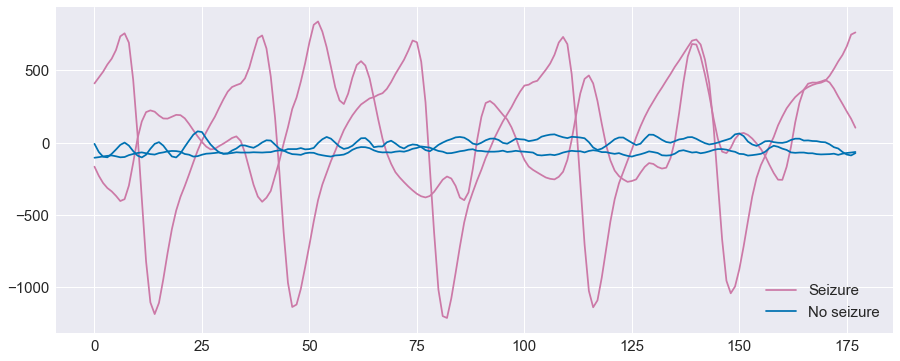

In [15]:
plot_seizure_vs_no_seizure(X[y_seizure_train_indices[2:4]], X[y_no_seizure_train_indices[2:4]])

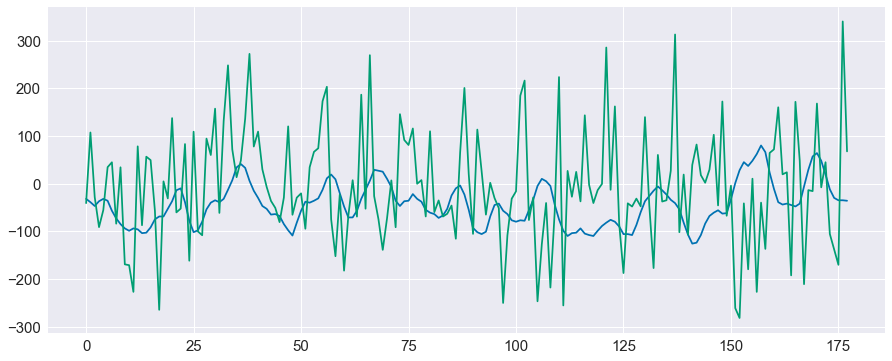

In [16]:
plot_data([X[2], X_sample[2]])

In [17]:
def encoding(vae_cls, x, save_path):
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, save_path)
        return sess.run(vae_cls.encoding, {vae_cls.x: x})

In [18]:
X_code = encoding(vae_cls, X_train, save_path)

INFO:tensorflow:Restoring parameters from ./vae.ckpt


In [19]:
def plot_encoding(X_code, y, figsize=(15, 8)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    vals = np.unique(y)
    
    data_per_class = collections.defaultdict(list)
    for i, v in enumerate(y):
        x_c = X_code[i]
        cls = 'Seizure' if v == 1 else 'No seizure'
        data_per_class[cls].append(x_c)
    
    for v in sorted(data_per_class.keys()):
        data = data_per_class[v]
        x1 = [i for i, _, _ in data]
        x2 = [j for _, j, _ in data]
        x3 = [k for _, _, k in data]
        ax.scatter(x1, x2, x3, label=v)
        
    ax.legend()

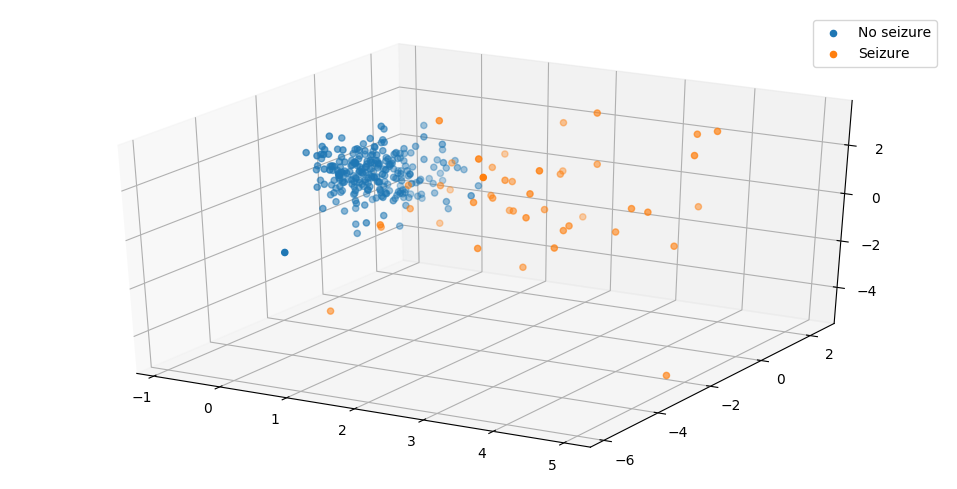

In [20]:
%matplotlib inline
sns.reset_orig()
n = 300
plot_encoding(X_code[:n], y_train[:n], (12, 6))

In [21]:
%%time
tsne = sklearn.manifold.TSNE(n_components=3, init='pca', learning_rate=200.0, random_state=222)
X_tsne = tsne.fit_transform(X_train[:300])

CPU times: user 10.7 s, sys: 1.05 s, total: 11.8 s
Wall time: 12.3 s


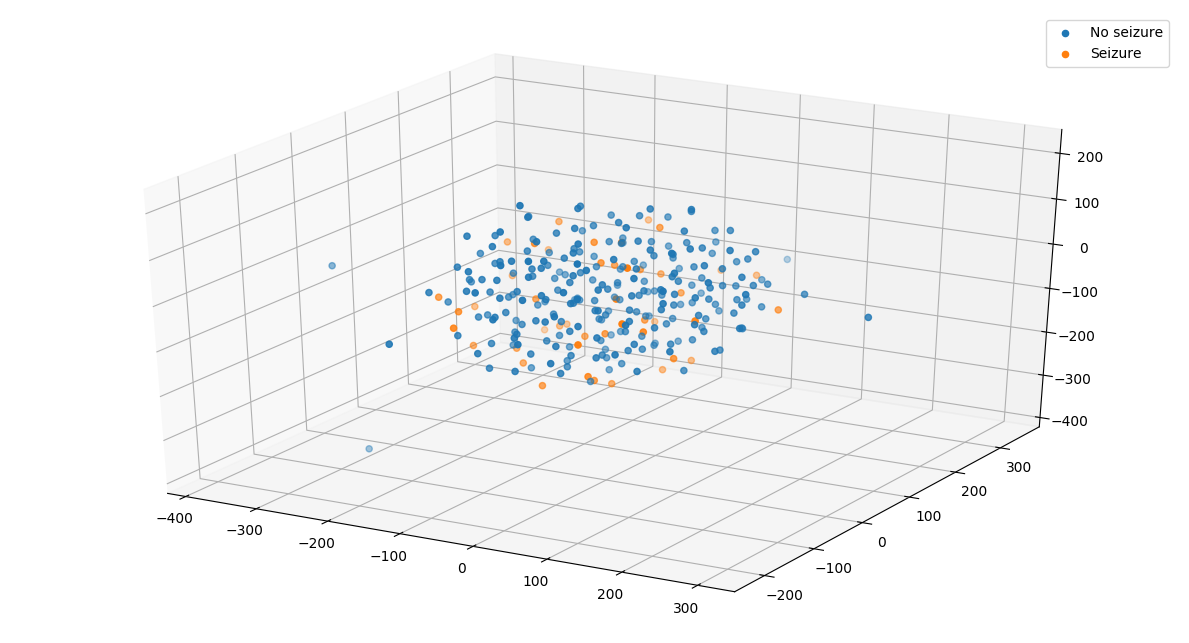

In [22]:
sns.reset_orig()
plot_encoding(X_tsne, y_train[:300])

## Clustering

In [23]:
db = sklearn.cluster.DBSCAN(eps=0.3, min_samples=10).fit(X_code)

In [24]:
db.labels_

array([ 0,  0,  0, ...,  0,  3, -1])

In [25]:
def plot_clusters(X, y):
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    vals = np.unique(y)
    
    data_per_class = collections.defaultdict(list)
    for i, v in enumerate(y):
        x_c = X_code[i]
        data_per_class[v].append(x_c)
    
    for v in sorted(data_per_class.keys()):
        data = data_per_class[v]
        x1 = [i for i, _, _ in data]
        x2 = [j for _, j, _ in data]
        x3 = [k for _, _, k in data]
        ax.scatter(x1, x2, x3, label=v)
        
    ax.legend()

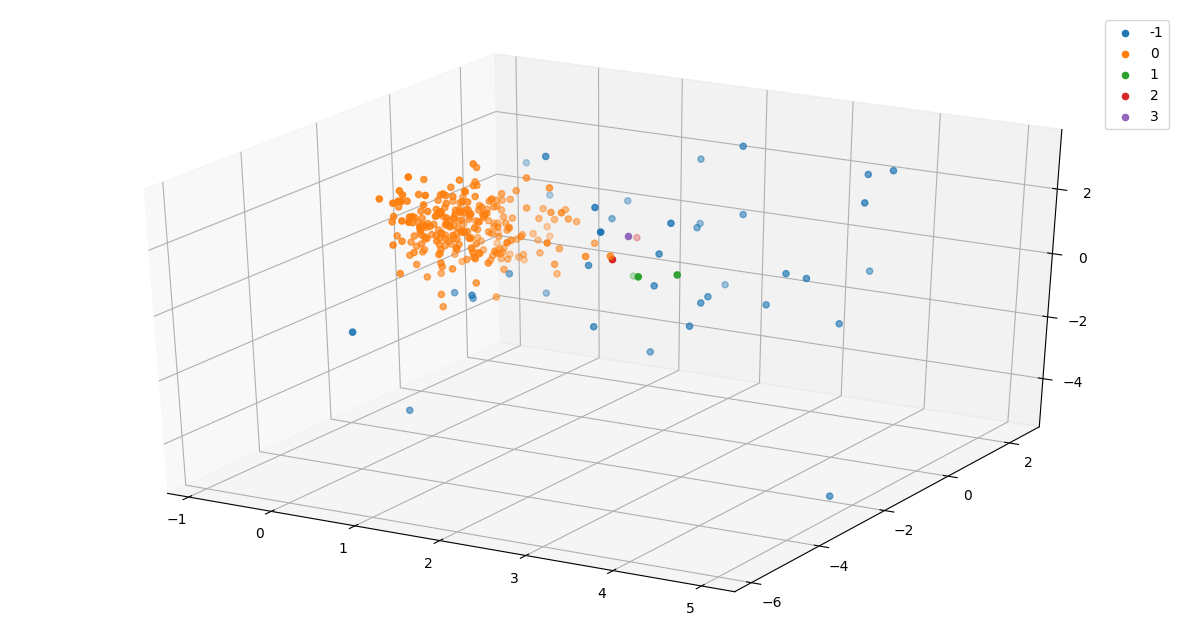

In [26]:
n = 300
sns.reset_orig()
plot_clusters(X_code[:n], db.labels_[:n])

In [27]:
def accuracy(predictions, actual):
    res = [
        1 if (l == 0 and actual[i] > 1) or (l == -1 and actual[i] == 1) else 0
        for i, l in enumerate(predictions)
    ]
    return 100 * sum(res) / len(res)

In [28]:
accuracy(db.labels_, y_train.values)

90.78260869565217

In [29]:
X_code_test = encoding(vae_cls, X_test, save_path)

INFO:tensorflow:Restoring parameters from ./vae.ckpt


In [30]:
db_test = sklearn.cluster.DBSCAN(eps=0.5, min_samples=20).fit(X_code_test)

In [31]:
accuracy(db_test.labels_, y_test.values)

94.43478260869566

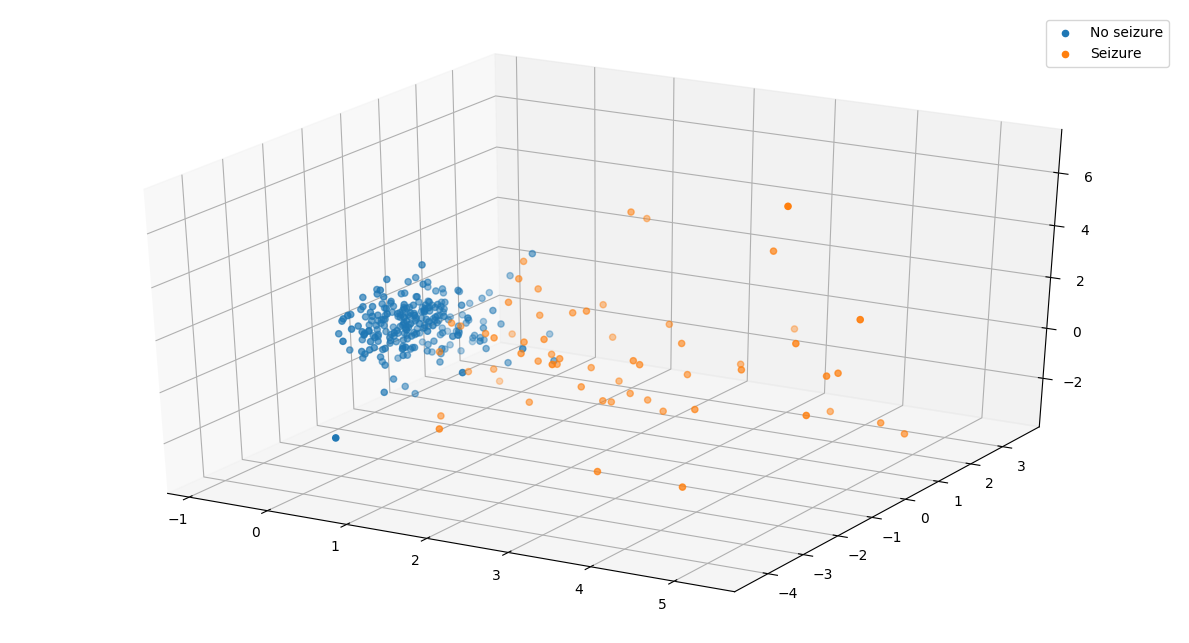

In [32]:
sns.reset_orig()
n = 300
plot_encoding(X_code_test[:n], y_test[:n])

## Classification

In [33]:
clasifier = BinaryClassifier(3, 5)

In [34]:
def train_classifier(classifier, x, y, x_test, y_test, learning_rate, n_epochs, batch_size):
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        tf.local_variables_initializer().run()
        
        for i, epoch in enumerate(range(n_epochs)):            
            x_batch, y_batch = random_draw(x, y, batch_size)
            
            sess.run(classifier.train_op, feed_dict={
                classifier.x: x_batch, 
                classifier.y: y_batch,
                classifier.learning_rate: learning_rate,
            })
            
            if i % 100 == 0:
                loss = sess.run(classifier.loss, {classifier.x: x_test, classifier.y: y_test})
                print(f'Iteration {i}: loss = {loss}')
                
        return saver.save(sess, f'./binary_classifier.ckpt')

In [35]:
bin_y = lambda y: np.array([0 if v > 1 else 1 for v in y])
y_train_bin, y_test_bin = bin_y(y_train), bin_y(y_test)

In [36]:
classifier_path = train_classifier(clasifier, X_code, y_train_bin, X_code_test, y_test_bin, 0.01, 1000, 100)

Iteration 0: loss = 0.7819623947143555
Iteration 100: loss = 0.12344840914011002
Iteration 200: loss = 0.09540585428476334
Iteration 300: loss = 0.09130945801734924
Iteration 400: loss = 0.09316837787628174
Iteration 500: loss = 0.0890907347202301
Iteration 600: loss = 0.09082551300525665
Iteration 700: loss = 0.08838801831007004
Iteration 800: loss = 0.08892490714788437
Iteration 900: loss = 0.08815648406744003


In [37]:
def get_classification_predictions(classifier, x, save_path):
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, save_path)
        return sess.run(classifier.outcome, {classifier.x: x})

In [38]:
def compute_outcome_and_accuracy(classifier, x, y, save_path):
    outcomes = get_classification_predictions(classifier, x, save_path)
    outcomes_bin = [0 if v < 0.5 else 1 for v in outcomes]
    accuracy = 100 * sum(1 if outcomes_bin[i] == y[i] else 0 for i in range(len(outcomes_bin))) / len(outcomes_bin)
    return outcomes_bin, accuracy

In [39]:
outcomes_test, accuracy_test = compute_outcome_and_accuracy(clasifier, X_code_test, y_test_bin, classifier_path)
accuracy_test

INFO:tensorflow:Restoring parameters from ./binary_classifier.ckpt


96.65217391304348

# Projection in higher dimensions

In [41]:
vae_gen = VariationalAutoEncoder(178, 267, hidden_layer_size=222, name='vae_gen')

In [42]:
gen_save_path = train_vae(vae_gen, X_train, X_test, 0.001, 10000, 100, name='vae_gen')

Iteration 0 / 50000: elbo test set = -21451.330078125
Iteration 1000 / 50000: elbo test set = -234.15133666992188
Iteration 2000 / 50000: elbo test set = -189.17086791992188
Iteration 3000 / 50000: elbo test set = -161.27499389648438
Iteration 4000 / 50000: elbo test set = -142.64340209960938
Iteration 5000 / 50000: elbo test set = -120.08087158203125
Iteration 6000 / 50000: elbo test set = -106.35210418701172
Iteration 7000 / 50000: elbo test set = -94.03060150146484
Iteration 8000 / 50000: elbo test set = -86.10533905029297
Iteration 9000 / 50000: elbo test set = -78.16724395751953
Iteration 10000 / 50000: elbo test set = -69.9476547241211
Iteration 11000 / 50000: elbo test set = -63.22553634643555
Iteration 12000 / 50000: elbo test set = -59.572425842285156
Iteration 13000 / 50000: elbo test set = -56.163230895996094
Iteration 14000 / 50000: elbo test set = -52.30999755859375
Iteration 15000 / 50000: elbo test set = -45.2536506652832
Iteration 16000 / 50000: elbo test set = -40.8658

KeyboardInterrupt: 

In [ ]:
X_gen = sample(vae_gen, 10, gen_save_path)
X_gen_s = scaler.inverse_transform(X_gen)

In [ ]:
plot_data([X[0], X_gen_s[5]])